# Shaw 2023
This looks at tracking the upper troposphere wind at a single latitude throughout the year.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.convection import lapse_moist, equivalent_potential_temp
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-01-17 08:54:21,415 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'ucomp', 'height', 'ucomp']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
sigma_levels = np.asarray(namelist['vert_coordinate_nml']['bk'][::-1])         # make first value the surface
# Sigma levels are at half pressure levels, so need to convolve to get pressure at full pressure levels.
sigma_levels = np.convolve(sigma_levels, np.ones(2)/2, 'valid')

## Get datasets
Get one surface dataset for summer for each $\kappa$

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 0           # Desired approximate pressure of free troposphere (hPa)
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used
lat_use = 35
# Keep 2 latitudes either side of desired so can compute the gradient.
n_lat_keep = 2
lat_ind_keep = np.arange(int(np.abs(ds[0].lat-lat_use).argmin())-n_lat_keep, int(np.abs(ds[0].lat-lat_use).argmin())+n_lat_keep+1)  
ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        # ds_use = ds[i].sel(pfull=[np.inf, pressure_ft], method='nearest').sel(time=slice(use_time_start, np.inf))
        # Keep all pressure levels, so can do thermal wind calculation
        ds_use = ds[i].sel(pfull=slice(pressure_ft, np.inf)).sel(time=slice(use_time_start, np.inf))    
        ds_use = ds_use.isel(pfull=slice(None, None, -1))       # make surface pressure the first index
        ds_use = ds_use.isel(lat=lat_ind_keep)  
        # if season == 'summer':
        #     ds_use = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh' if lat_use>0 else 'sh']).sel(lat=slice(0, 90))  
        ds_use = annual_mean(ds_use)        # take annual mean so only have 360 time indices
        ds_use = ds_use.transpose('pfull', 'lat', 'lon', 'time')        # make time the last index
        ds_all += [ds_use.load()]
        pbar.update(1)
p_surface = float(ds_all[0].pfull[0]) * 100
pressure_ft_actual = float(ds_all[0].pfull[-1]) * 100       # Actual pressure of free troposphere (Pa)
sigma_levels_use = sigma_levels[:len(ds_all[0].pfull)]      # Not all sigma levels are kept
lat_use_actual = float(ds_all[0].lat[n_lat_keep])

100%|██████████| 2/2 [00:23<00:00, 11.80s/it]


## Compare $\partial T/\partial x$ vs $\partial T/\partial y$
Below we want to see which gradients are larger in the free troposphere, zonal or meridional. We also want to see which change the most with warming.

In both cases, it seems the answer is meridional: $|\partial T/ \partial y| >> |\partial T/ \partial x|$, as shown by the different y-axis used.

The solid (dotted) lines indicate the $\kappa=1$ ($\kappa=1.5$) simulations.


In [5]:
def get_gradient(var, lon, lat):
    # Returns d/dx and d/dy
    # Axis 0 is pressure, axis 1 is latitude, axis 2 is lon and axis 3 is time
    lon = np.asarray(np.deg2rad(lon))
    lat = np.asarray(np.deg2rad(lat))
    d_var_dx = (1/radius_earth*np.cos(lat)[np.newaxis, :, np.newaxis, np.newaxis]) * np.gradient(var, lon, axis=2)
    d_var_dy = (1/radius_earth) * np.gradient(var, lat, axis=1)
    return d_var_dx, d_var_dy

In [6]:
n_pressure, _, _, n_time = ds_all[0].temp.shape
d_temp_dx = np.zeros((n_exp, n_pressure, n_time))
d_temp_dy = np.zeros((n_exp, n_pressure, n_time))
for i in range(n_exp):
    temp_grad_use = get_gradient(ds_all[i].temp, ds_all[i].lon, ds_all[i].lat)
    d_temp_dx[i] = np.mean(temp_grad_use[0][:, n_lat_keep], axis=1)     # only take one latitude, and take zonal mean
    d_temp_dy[i] = np.mean(temp_grad_use[1][:, n_lat_keep], axis=1)     # only take one latitude, and take zonal mean

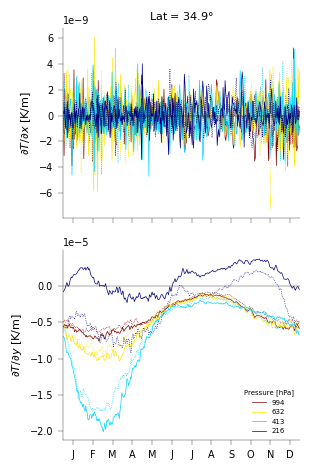

In [7]:
pressure_ft_plot = ds_all[0].pfull.sel(pfull=[1000, 600, 400, 200], method='nearest')        # choose 3 pressure levels
pressure_ft_plot_ind = numpy_indexed.indices(ds_all[0].pfull, pressure_ft_plot)
n_pressure_plot = len(pressure_ft_plot_ind)
color_seq_pressure = plt.cm.jet(np.linspace(0,1,n_pressure_plot))[::-1]       # make near-surface red

time_array = ds_all[0].time-0.5
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

save_T_grad_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_plot):
    ax[0].plot(time_array, d_temp_dx[0, pressure_ft_plot_ind[i]], color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))
    ax[0].plot(time_array, d_temp_dx[1, pressure_ft_plot_ind[i]], color=color_seq_pressure[i], linestyle=':')

    ax[1].plot(time_array, d_temp_dy[0, pressure_ft_plot_ind[i]], color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))
    ax[1].plot(time_array, d_temp_dy[1, pressure_ft_plot_ind[i]], color=color_seq_pressure[i], linestyle=':')
ax[0].hlines(0, -1, n_time, color='k', lw=ax_linewidth)
ax[1].hlines(0, -1, n_time, color='k', lw=ax_linewidth)
ax[1].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[0].set_ylabel('$\partial T/\partial x$ [K/m]')
ax[1].set_ylabel('$\partial T/\partial y$ [K/m]')
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, n_time)
ax[0].set_title(f'Lat = ${round(lat_use_actual, 1)}\degree$')
plt.tight_layout()

if save_fig or save_T_grad_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/T_gradient_time.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Decompose $\partial T/\partial y$
As we are satisfied that the temperature gradient in the free troposphere is dominated by the meridional, below I just consider this.

I decompose the gradient into a monthly average and a deviation from this.

It seems that when we consider changes with warming, the changes to the monthly average dominate changes to the deviation.

In [8]:
def get_monthly_average(var, time_axis=-1, n_month_days=30):
    """
    Replaces the value of var at a given day with the monthy average value
    
    Args:
        var: Variable to average
        time_axis: Index of time axis in var
        n_month_days: Number of days in each month
        
    Returns:
        Returned variable has same dimensions as var but the monthly average will be 
        repeated for all days in that month.
    """
    n_months = var.shape[time_axis]/n_month_days
    if n_months % 1 != 0:
        raise ValueError('There are not an integer number of months in the data set')
    n_months = int(n_months)
    var = np.moveaxis(var, time_axis, 0)     # make time the first axis
    var_av = np.zeros_like(var)
    for i in range(n_months):
        var_av[i*n_month_days: (i+1)*n_month_days] = np.mean(var[i*n_month_days: (i+1)*n_month_days], axis=0)
    return np.moveaxis(var_av, 0, time_axis)

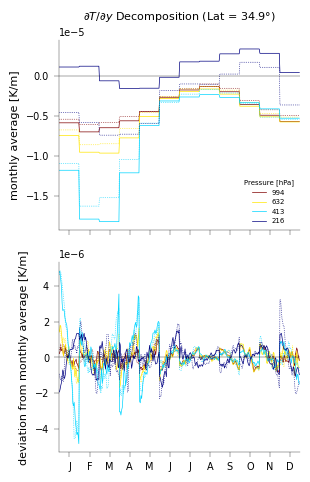

In [9]:
# Decompose meridional gradient into monthly average and deviation from this
save_T_grad_y_decomp_fig = False

d_temp_dy_av = get_monthly_average(d_temp_dy)
d_temp_dy_dev = d_temp_dy - d_temp_dy_av
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_plot):
    ax[0].plot(time_array, d_temp_dy_av[0, pressure_ft_plot_ind[i]], color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))
    ax[0].plot(time_array, d_temp_dy_av[1, pressure_ft_plot_ind[i]], color=color_seq_pressure[i], linestyle=':')
    
    ax[1].plot(time_array, d_temp_dy_dev[0, pressure_ft_plot_ind[i]], color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))
    ax[1].plot(time_array, d_temp_dy_dev[1, pressure_ft_plot_ind[i]], color=color_seq_pressure[i], linestyle=':')
    
ax[0].hlines(0, -1, n_time, color='k', lw=ax_linewidth)
ax[1].hlines(0, -1, n_time, color='k', lw=ax_linewidth)
ax[0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[0].set_ylabel('monthly average [K/m]')
ax[1].set_ylabel('deviation from monthly average [K/m]')
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, n_time)
ax[0].set_title(f'$\partial T/\partial y$ Decomposition (Lat = ${round(lat_use_actual, 1)}\degree$)')
plt.tight_layout()
if save_fig or save_T_grad_y_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/T_gradient_y_decomp_time.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

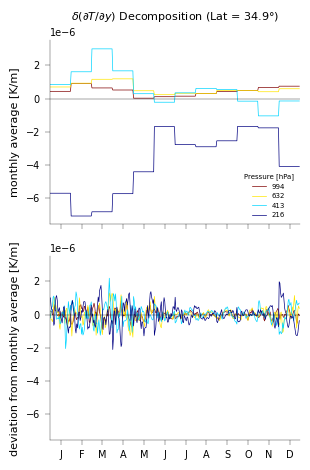

In [10]:
# Decompose changes in meridional gradient into monthly average and deviation from this
save_delta_T_grad_y_decomp_fig = False

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
for i in range(n_pressure_plot):
    ax[0].plot(time_array, d_temp_dy_av[1, pressure_ft_plot_ind[i]]-d_temp_dy_av[0, pressure_ft_plot_ind[i]], 
               color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))
    
    ax[1].plot(time_array, d_temp_dy_dev[1, pressure_ft_plot_ind[i]]-d_temp_dy_dev[0, pressure_ft_plot_ind[i]], 
               color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))

ax[0].hlines(0, -1, n_time, color='k', lw=ax_linewidth)
ax[1].hlines(0, -1, n_time, color='k', lw=ax_linewidth)
ax[0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[0].set_ylabel('monthly average [K/m]')
ax[1].set_ylabel('deviation from monthly average [K/m]')
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, n_time)
ax[0].set_title(f'$\delta(\partial T/\partial y)$ Decomposition (Lat = ${round(lat_use_actual, 1)}\degree$)')
plt.tight_layout()
if save_fig or save_delta_T_grad_y_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_T_gradient_y_decomp_time.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Free Troposphere MSE
Below, I make similar plots to above but for saturated moist static energy. The idea is to see if there is a connection between the two.

It doesn't appear that there is much correlation between the two.

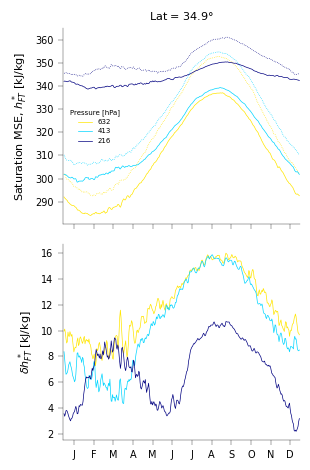

In [11]:
ds_mse = [ds_all[i].mean(dim='lon').isel(pfull=pressure_ft_plot_ind, lat=n_lat_keep) for i in range(n_exp)]
mse_sat = np.asarray([moist_static_energy(ds_mse[i].temp, sphum_sat(ds_mse[i].temp, ds_mse[i].pfull*100), ds_mse[i].height) 
                      for i in range(n_exp)])

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(1, n_pressure_plot):
    ax[0].plot(time_array, mse_sat[0, i], color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))
    ax[0].plot(time_array, mse_sat[1, i], color=color_seq_pressure[i], linestyle=':')

    ax[1].plot(time_array, mse_sat[1, i]-mse_sat[0, i], color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))

ax[0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[0].set_ylabel('Saturation MSE, $h_{FT}^*$ [kJ/kg]')
ax[1].set_ylabel('$\delta h_{FT}^*$ [kJ/kg]')
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, n_time)
ax[0].set_title(f'Lat = ${round(lat_use_actual, 1)}\degree$')
plt.tight_layout()

Below I show that in the upper troposphere, the variation in saturation MSE is dominated by changes in temperature.

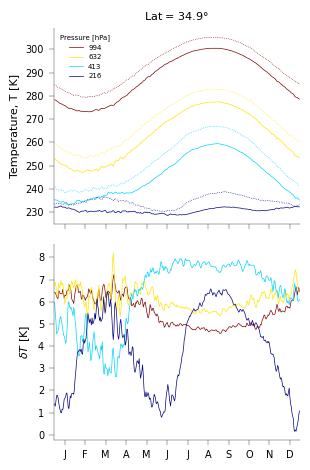

In [12]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_pressure_plot):
    ax[0].plot(time_array, ds_mse[0].temp[i], color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))
    ax[0].plot(time_array, ds_mse[1].temp[i], color=color_seq_pressure[i], linestyle=':')

    ax[1].plot(time_array, ds_mse[1].temp[i]-ds_mse[0].temp[i], color=color_seq_pressure[i], label=int(pressure_ft_plot[i]))

ax[0].legend(fontsize=5, title='Pressure [hPa]', title_fontsize=5)
ax[0].set_ylabel('Temperature, T [K]')
ax[1].set_ylabel('$\delta T$ [K]')
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, n_time)
ax[0].set_title(f'Lat = ${round(lat_use_actual, 1)}\degree$')
plt.tight_layout()

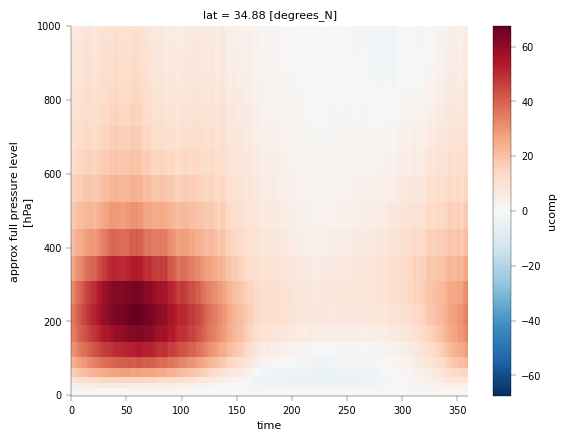

In [16]:
ds_all[0].ucomp[:, n_lat_keep].mean(dim='lon').plot()

## Compare wind to thermal wind
Here I see if the thermal wind calculation matches the actual wind speed at different pressure levels in the atmosphere.

In [29]:
def get_wind_thermal_cumulative(temp, pressure, lon, lat):
    """
    Equation 1 in the paper. Returns wind using every pressure level as an upper bound.
    Args:
        temp: [n_pressure x n_lat x n_lon x n_time] in K
        pressure: [n_pressure] in Pa
            First value is the near-surface pressure
        lon: [n_lon] in deg
        lat: [n_lat] in deg

    Returns:
        u_thermal: [n_pressure x n_lat x n_lon x n_time] in m/s
        v_thermal: [n_pressure x n_lat x n_lon x n_time] in m/s
    """
    d_temp_dx, d_temp_dy = get_gradient(temp, lon, lat)
    n_pressure, n_lat, n_lon, n_time = d_temp_dx.shape
    f_coriolis = 2 * rot_earth * np.sin(np.deg2rad(lat).to_numpy()).reshape(1, n_lat, 1, 1)
    integrand_v = -d_temp_dx * R / (pressure.to_numpy().reshape(n_pressure, 1, 1, 1) * f_coriolis)
    integrand_u = d_temp_dy * R / (pressure.to_numpy().reshape(n_pressure, 1, 1, 1) * f_coriolis)
    return (scipy.integrate.cumulative_trapezoid(integrand_u, pressure, axis=0, initial=0), 
            scipy.integrate.cumulative_trapezoid(integrand_v, pressure, axis=0, initial=0))

In [31]:
a, b = get_wind_thermal_cumulative(ds_all[0].temp, ds_all[0].pfull, ds_all[0].lon, ds_all[0].lat)

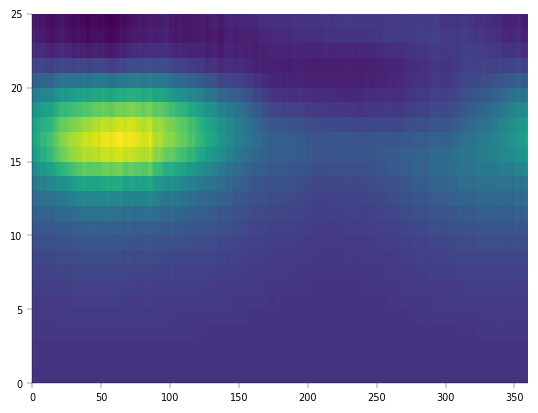

In [35]:
plt.pcolormesh(np.mean(a[:, n_lat_keep], axis=1))

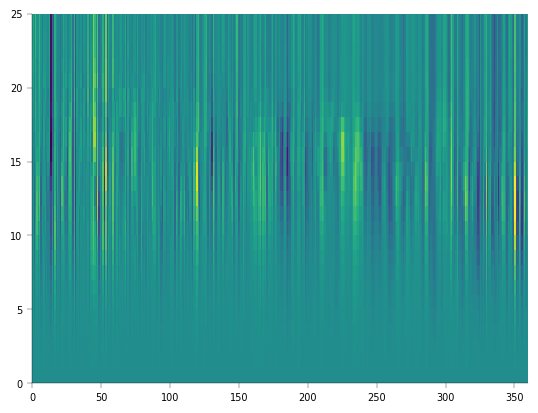

In [36]:
plt.pcolormesh(np.mean(b[:, n_lat_keep], axis=1))

In [26]:
a, b = get_gradient(ds_all[0].temp, ds_all[0].lon, ds_all[0].lat)
f_coriolis = 2 * rot_earth * np.sin(np.deg2rad(ds_all[0].lat).to_numpy()).reshape(1, 5, 1, 1)
a/f_coriolis

array([[[[ 1.03655147e-03,  1.41224166e-02,  2.13687237e-02, ...,
           7.11017010e-03, -7.20451063e-03, -5.89449115e-03],
         [ 1.28553880e-03,  7.66188314e-03,  2.09543434e-02, ...,
           1.33456011e-02, -4.30145008e-03, -4.79345381e-03],
         [ 1.32434985e-03, -1.98115091e-03,  1.54891599e-02, ...,
           2.01703608e-02,  4.67284127e-03, -1.58587600e-03],
         ...,
         [ 1.28768834e-02,  2.02169339e-02,  2.96026223e-02, ...,
          -2.22058466e-03, -7.96640017e-03, -1.51512064e-02],
         [ 6.91133873e-03,  2.59161754e-02,  2.73730808e-02, ...,
           1.03834279e-03, -7.19853969e-03, -1.00192016e-02],
         [ 4.58088902e-03,  2.87846057e-02,  2.50193432e-02, ...,
           1.85695573e-03, -6.57278720e-03, -6.98836319e-03]],

        [[-6.87171068e-04,  2.24458076e-02,  1.70756130e-02, ...,
           2.55097564e-03, -7.15170874e-03, -7.81964389e-03],
         [-8.59765354e-04,  1.41436489e-02,  1.82522476e-02, ...,
           6.13217391e